In [ ]:
!pip install hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
from PIL import Image
# import tensorflow as tf
from sklearn import decomposition
import cv2
from sklearn.model_selection import train_test_split
from hmmlearn import hmm
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
LABELS =  ['call_me', 'fingers_crossed', 'okay', 'paper', 'peace', 'rock', 'rock_on', 'scissor', 'thumbs', 'up']
LABELS_TO_INDEX = {k: v for v, k in enumerate(LABELS)}
INDEX_TO_LABELS = {k: v for k, v in enumerate(LABELS)}

In [7]:
# if no dataset folder, extract it
if not os.path.exists('datasets/'):
    !unzip -q datasets.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [11]:
images = []
train_labels = []
for label_name in LABELS:
    folder_path = 'datasets/HandGesture/images/' + label_name
    for filename in os.listdir(folder_path):
        img = Image.open(os.path.join(folder_path, filename))
        if img.mode != 'L':
            img = img.convert('L')
        img_arr = np.array(img)
        images.append(img_arr)
        train_labels.append(label_name)
images = np.array(images)
print(images.shape)

(5243, 195, 240)


In [12]:
img_shape = images[0].shape                         # 195 x 240
X = images.reshape(images.shape[0], -1)             # flatten 195 x 240 image
y = np.vectorize(LABELS_TO_INDEX.get)(train_labels) # convert label name to index (call_me -> 0)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (3670, 46800)
y_train (3670,)
X_test (1573, 46800)
y_test (1573,)


# Feature Extraction using PCA

In [15]:
standardized_scalar = StandardScaler()
standardized_data = standardized_scalar.fit_transform(X)
standardized_data.shape

(5243, 46800)

In [ ]:
# cov_matrix = np.matmul(standardized_data.T, standardized_data)
# cov_matrix.shape

In [ ]:
# Warning: this takes 6 minutes to run
pca = decomposition.PCA(n_components = 0.95) # 95% of variance
principal_components = pca.fit_transform(standardized_data)

In [ ]:
print('Total Variance:', sum(pca.explained_variance_ratio_))
print('Number of Components:', pca.n_components_)
print(principal_components.shape)

Total Variance: 0.9500339647447117
Number of Components: 908
(5243, 908)


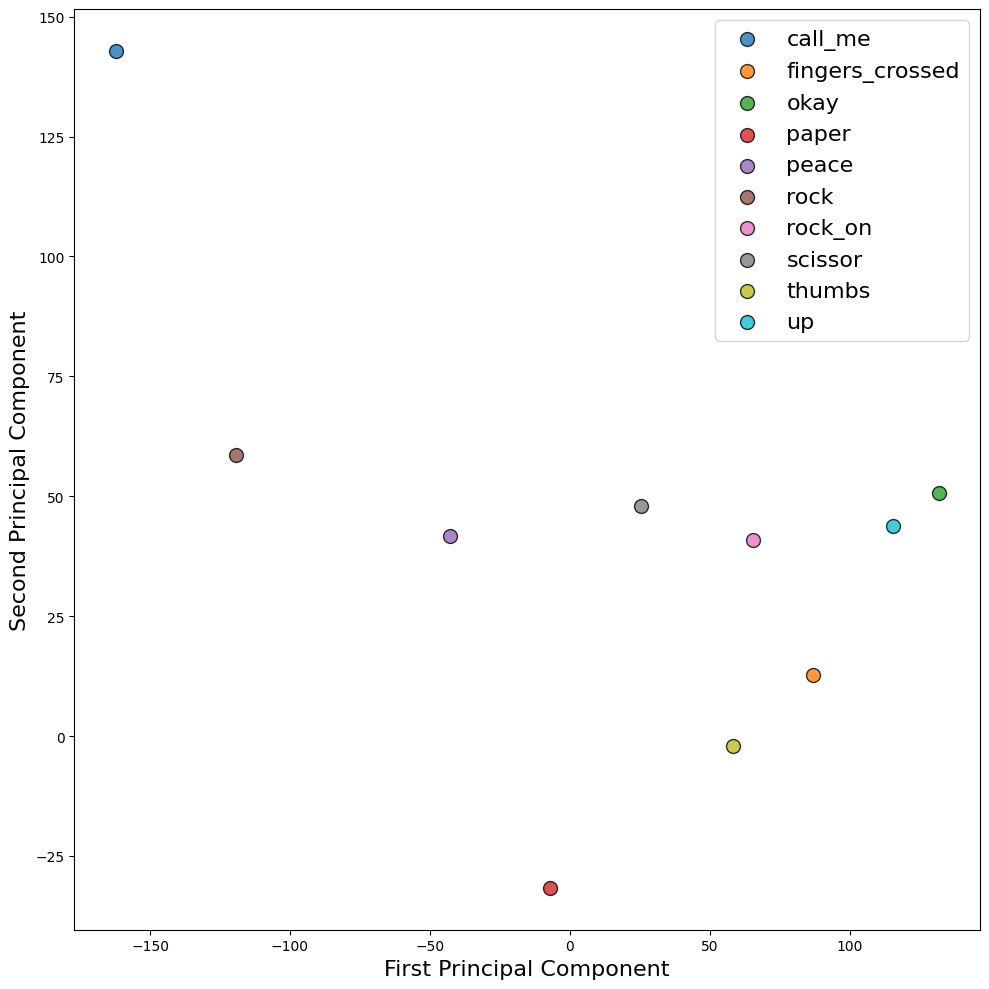

In [ ]:
plt.figure(figsize=(10, 10))

colors = plt.cm.tab10(np.linspace(0, 1, len(LABELS)))

for label, color in zip(LABELS, colors):
    indices = [i for i, l in enumerate(LABELS) if l == label]
    plt.scatter(principal_components[indices, 0], principal_components[indices, 1], 
                c=[color], label=label, edgecolors='k', alpha=0.8, s=100)

plt.xlabel('First Principal Component', fontsize='16')
plt.ylabel('Second Principal Component', fontsize='16')
plt.legend(loc='best', fontsize='16')
plt.tight_layout()
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, train_labels, test_size=0.3, random_state=0)

# Feature Extration with HOG

In [ ]:
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import data, exposure
import matplotlib.pyplot as plt
import io


fds = []
hog_img_list = []
ori_img_list = []

max_hog_display = 10  # Display 10 HOG images, change it if different number of HOG images is desired
count = 0

for i in range(len(images)):
    img_resized = resize(images[i], (100,100)) 

    fd, hog_img = hog(img_resized, orientations=9, pixels_per_cell=(8, 8), 
                        cells_per_block=(2, 2), visualize=True)
    
    fds.append(fd)
    
    if count < max_hog_display:
        hog_img_list.append(hog_img)
        ori_img_list.append(img_resized)
    
    count +=1
    

for i in range(len(hog_img_list)):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True) 

    ax1.imshow(ori_img_list[i], cmap=plt.cm.gray) 
    ax1.set_title('Original image') 

    # Rescale histogram
    hog_image_rescaled = exposure.rescale_intensity(hog_img_list[i], in_range=(0, 10)) 

    ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
    ax2.set_title('HOG')

    plt.show()

KeyboardInterrupt: ignored

# Classification Using K-Means

In [ ]:
img = images[0] # warning: this is a uint8
plt.imshow(img, cmap=plt.cm.gray)

from sklearn.cluster import KMeans, MiniBatchKMeans

# Perform K Means
K = 100 # begin with 10 (number of gesture labels), increase to much much more as necessary
kmeans = MiniBatchKMeans(n_clusters = K)
kmeans.fit(X_train)

In [ ]:
print(kmeans.labels_) # cluster labels for each training image
print(kmeans.cluster_centers_.shape) # K clusters x 46800 pixels

def visualize_all_clusters(kmeans):
    fig=plt.figure()
    columns = 10
    rows = 10

    for i in range(1, columns*rows + 1):
        center = kmeans.cluster_centers_[i-1].reshape((img_shape))
        fig.add_subplot(rows, columns, i)
        plt.axis('off')
        plt.imshow(center)

# for each KMeans cluster, get the most probable label
# return mapping from cluster to label
def cluster_to_index(cluster_labels, y_train):
    index_labels = {}
    for i in range(len(np.unique(kmeans.labels_))):
        index = np.where(cluster_labels == i,1,0)
        num = np.bincount(y_train[index==1]).argmax()
        index_labels[i] = num
    return index_labels

CLUSTERS_TO_INDEX = cluster_to_index(kmeans.labels_, y_train)
print(CLUSTERS_TO_INDEX)

visualize_all_clusters(kmeans)

In [ ]:
# Get test results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

cluster_ids = kmeans.predict(X_test)
y_pred = np.vectorize(CLUSTERS_TO_INDEX.get)(cluster_ids)

print('Accuracy:',  accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='micro'))
print('Recall:',    recall_score(y_test, y_pred, average='micro'))
print('F1:',        f1_score(y_test, y_pred, average='micro'))

In [ ]:
# take 10 test images, predict them, and display them
N = 10
fig, axs = plt.subplots(N, 2, sharex='all', sharey='all', figsize=(10, 10*N))

imgs = X_test[:N]
cluster_ids = kmeans.predict(imgs) # cluster index

for i in range(N):
    img = imgs[i]
    cluster_id = cluster_ids[i]
    cluster = kmeans.cluster_centers_[cluster_id].reshape((img_shape)) # cluster image

    true_label = INDEX_TO_LABELS[y_test[i]]
    pred_label = INDEX_TO_LABELS[CLUSTERS_TO_INDEX[cluster_id]]

    axs[i, 0].imshow(cluster, cmap=plt.cm.gray)
    axs[i, 0].set_title('Prediction: {}'.format(pred_label))

    axs[i, 1].imshow(img.reshape((img_shape)), cmap=plt.cm.gray)
    axs[i, 1].set_title('Actual: {}'.format(true_label))

# Prediction using Random Forest

In [ ]:
def resize_image(image_array, target_size=(32, 32)):
    image = Image.fromarray(image_array)
    return np.array(image.resize(target_size, Image.ANTIALIAS))

resized_images = [resize_image(img) for img in images]
resized_images_array = np.array(resized_images)

In [ ]:
X = resized_images_array.reshape(resized_images_array.shape[0], -1)
X = standardized_scalar.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = rf_classifier.predict(X_test)

In [ ]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95       155
           1       0.83      0.93      0.88       149
           2       0.86      0.86      0.86       152
           3       0.86      0.66      0.75       164
           4       0.77      0.84      0.80       148
           5       0.89      0.88      0.88       159
           6       0.94      0.92      0.93       151
           7       0.83      0.83      0.83       157
           8       0.94      0.97      0.96       176
           9       0.96      0.93      0.94       162

    accuracy                           0.88      1573
   macro avg       0.88      0.88      0.88      1573
weighted avg       0.88      0.88      0.88      1573

Confusion Matrix:
 [[151   0   0   0   0   0   0   0   4   0]
 [  0 138   0   0   4   1   3   3   0   0]
 [  0   0 130  14   0   6   0   1   0   1]
 [  0   3  21 109  15   3   1   7   1   4]
 [  0  10   0   0 125   1 

# Prediction using Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# X = resized_images_array.reshape(resized_images_array.shape[0], -1)
X = principal_components
X = standardized_scalar.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
clf.fit(X_train, y_train) # takes 6 min!

y_pred = clf.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85       155
           1       0.81      0.78      0.79       149
           2       0.68      0.72      0.70       152
           3       0.69      0.54      0.60       164
           4       0.69      0.78      0.73       148
           5       0.89      0.86      0.87       159
           6       0.86      0.88      0.87       151
           7       0.65      0.69      0.67       157
           8       0.87      0.89      0.88       176
           9       0.85      0.83      0.84       162

    accuracy                           0.78      1573
   macro avg       0.78      0.78      0.78      1573
weighted avg       0.79      0.78      0.78      1573

Confusion Matrix:
 [[134   0   4   2   0   1   1   4   9   0]
 [  0 116   1   2  12   0   4  10   4   0]
 [  3   0 110  20   2   7   2   1   0   7]
 [  1   3  34  88  13   2   5  13   0   5]
 [  0   5   1   2 116   2 

# Prediction using SVM

In [ ]:
components_num = 908
pca = decomposition.PCA(n_components = components_num)
principal_components = pca.fit_transform(standardized_data)
X_train, X_test, y_train, y_test = train_test_split(principal_components, y, test_size=0.3, random_state=0)

In [43]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [44]:
y_pred = clf.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

0.6102987921169739